<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula04b_MLP_single_hidden_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

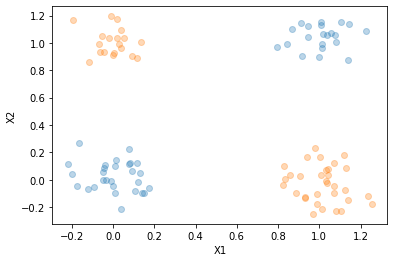

In [120]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def criaDatasetBidimensionalBinárioNãoLinearmenteSeparável(n=20, n_classes=3):
    """
    Cria um dataset bidimensional Binário não linearmente separável.
    """
    X, y = make_blobs(n_samples=n, centers=[[0,0],[1,0],[1,1],[0,1]], cluster_std=0.1)
    y = np.array(y%2, dtype=int)
    return X, y

X, y = criaDatasetBidimensionalBinárioNãoLinearmenteSeparável(1000)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.9)


def plotaDatasetBidimensional(X, y):
    """
    Plota um dataset bidimensional.
    """
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)

plotaDatasetBidimensional(Xtr, ytr)

def define_axes(X):
    offset = 0.2
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-offset, max1+offset, min2-offset, max2+offset]

def plot_predictions(clf, X):
    axes = define_axes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

In [121]:
def accuracy(yactual, ypred):
    return sum(yactual == ypred)/len(yactual)

In [122]:
from scipy.special import expit

def tanh(a):
  return expit(a)*2-1

In [132]:
from abc import ABC, abstractstaticmethod

class Custo(ABC):
    @abstractstaticmethod
    def custo(y, ypred):
        pass
    @abstractstaticmethod
    def gradiente(y, ypred, X):
        pass

class WidrowHoff(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum((1 - (y * ypred))**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - ypred)

In [133]:
from abc import ABC, abstractmethod

class TrainingAlgorithm(ABC):
    @abstractmethod
    def getW(self, X, y, activation):
        pass


class PseudoInversa(TrainingAlgorithm):
    def __init__(self, regularization=0):
        self.regularization = regularization
    def getW(self, X, y):
        if self.regularization == 0:
            return np.linalg.pinv(X) @ y
        return np.linalg.inv(X.T @ X + np.eye(X.shape[1])*self.regularization) @ X.T @ y


class DescidaGradiente(TrainingAlgorithm):
    def __init__(self, max_iter=1000, learning_rate=0.005, 
                       regularization=0, cost=WidrowHoff()):
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.cost = cost

    def getW(self, X, y):
        w = np.random.uniform(-1, 1, size=(X.shape[1], y.shape[1]))
        for _ in range(self.max_iter):
            ypred = X @ w
            if self.cost.custo(y, ypred) == 0:
                break
            w *= 1 - self.regularization * self.learning_rate
            w += self.cost.gradiente(y, ypred, X) * self.learning_rate
        return w

In [134]:
def include_bias(X):
  bias = np.ones((X.shape[0], 1))
  Xb = np.concatenate((bias, X), axis=1)
  return Xb

class FixedWeights():
  def __init__(self):
    self.activation = tanh
    self.n_hidden = 2

  def fit(self, X, y):
    self.ihw = np.array([[1.75, 0.9, -0.9], [-1.75, 0.9, -0.9]]).T
    self.how = np.array([1.234, -0.9, 0.9])

  def predict(self, X):
    Xb = include_bias(X)
    H = self.activation(Xb @ self.ihw)
    Hb = include_bias(H)
    return Hb @ self.how

In [135]:
class TrainingLastLayer():
  def __init__(self, training_algorithm=DescidaGradiente()):
    self.activation = tanh
    self.n_hidden = 2
    self.training_algorithm = training_algorithm

  def fit(self, X, y):
    Xb = include_bias(X)
    self.ihw = np.array([[1.75, 0.9, -0.9], [-1.75, 0.9, -0.9]]).T
    H = self.activation(Xb @ self.ihw)
    Hb = include_bias(H)
    self.how = self.training_algorithm.getW(Hb, y)

  def predict(self, X):
    Xb = include_bias(X)
    H = self.activation(Xb @ self.ihw)
    Hb = include_bias(H)
    return Hb @ self.how

In [138]:
class Backpropagation():
  def __init__(self):
    self.n_hidden = 2
    self.activation = tanh
    self.learning_rate = 0.005
    self.max_iter = 1000

  def forward(self):
    self.pH = self.Xb @ self.ihw
    self.H = self.activation(self.pH)
    self.Hb = include_bias(self.H)
    self.py = self.Hb @ self.how
  
  def backward(self, y):
    ho_delta = y - self.py
    ho_grad = self.Hb.T @ ho_delta
    ### PULO DO GATO ###
    tanh_grad = (1 - np.square(tanh(self.pH)))
    ih_delta = (ho_delta @ self.how[1:,:].T) * tanh_grad
    ### ### ###
    ih_grad = self.Xb.T @ ih_delta
    self.how += ho_grad * self.learning_rate
    self.ihw += ih_grad * self.learning_rate

  def fit(self, X, y):
    self.Xb = include_bias(X)
    self.ihw = np.random.uniform(-1, 1, size=(self.Xb.shape[1], self.n_hidden))
    self.how = np.random.uniform(-1, 1, size=(self.n_hidden+1, y.shape[1]))
    for _ in range(self.max_iter):
      self.forward()
      self.backward(y)

  def predict(self, X):
    Xb = include_bias(X)
    H = self.activation(Xb @ self.ihw)
    Hb = include_bias(H)
    return Hb @ self.how

1.0


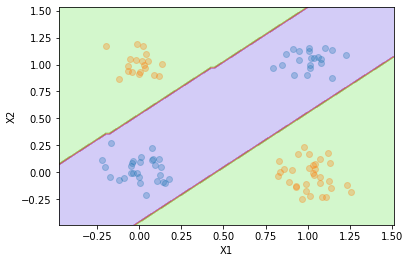

In [139]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

class MLP(BaseEstimator, ClassifierMixin):
  def __init__(self, training_algorithm=Backpropagation()):
    self.training_algorithm = training_algorithm

  def encode_labels(self, y):
    self.labels = list(set(y))
    return label_binarize(y, classes=self.labels)*2-1

  def fit(self, X, y):
    yhot = self.encode_labels(y)
    self.training_algorithm.fit(X, yhot)
    return self

  def predict(self, X):
    a = self.training_algorithm.predict(X)
    if len(self.labels) <= 2:
      idx = np.array(a > 0, dtype=int).reshape((-1,))
    else:
      idx = np.argmax(a, axis=1)
    ypred = np.array([self.labels[i] for i in idx])
    return ypred

elm = MLP()
elm.fit(Xtr, ytr)
print(accuracy(ytr, elm.predict(Xtr)))
plotaDatasetBidimensional(Xtr, ytr)
plot_predictions(elm, Xte)